In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In this Kaggle competition we need to the predict the value of transaction each customers will carry out given a set of features. 

In [2]:
#Load the training set
train = pd.read_csv('train.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [5]:
#Check for any NaN in the dataframe
train.isnull().values.any()

False

In [6]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


The features are anonymized

In [7]:
test = pd.read_csv('test.csv')

Let us look more into the training dataset and look at the mean, S.D and variance of the features.

In [19]:
features_train = train.describe().T

In [20]:
np.sum(features_train['std']<=0)

256

We see that we have at least 256 features that have zero standard deviation which means that they are just a constant term and can be removed from the dataset. But we must also confirm that we have the same number from the test set too

In [21]:
features_test = test.describe().T

In [27]:
np.sum(features_test['std']<=0.0)

0

The std for all the features seems to be non-zero for the test set. We will thus not remove any data as of now

### Plotting the target distribution

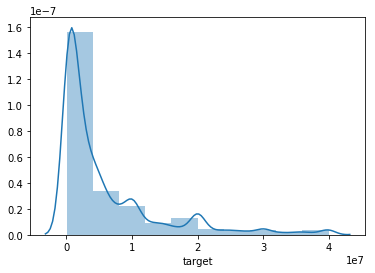

In [31]:
sns.distplot(train['target'], bins = 10)

The target is heavily skewed towards zero. Let us take a logarithm of the target and then take a histogram.

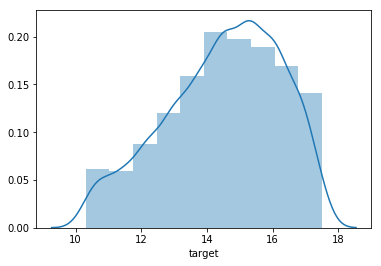

In [32]:
sns.distplot(np.log1p(train['target']), bins = 10)

Because of the presence of several zeroes in the target, it was tranformed using $log\left(1+x\right)$ to avoid null values. It will also be much easier to deal with this transformed target for the purposes of any sort of predictive analysis and modelling. This can be easily reversed using the function $e^x-1$.

In [34]:
X = train.iloc[:, 2:].values
y = np.log1p(train.iloc[:, 1].values)# to make it easier to carry out modeling 

In [42]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Random Forest Trial

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

In [44]:
model_rf = RandomForestRegressor(n_estimators= 1000, criterion= 'mse', max_depth= 30,
                              min_samples_split=5, min_samples_leaf= 2,max_features='auto',
                              bootstrap= 'True')

In [45]:
print(model_rf.get_params())

{'bootstrap': 'True', 'criterion': 'mse', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [46]:
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap='True', criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)